## CIFAR10 EXPERIMENTS

### NOTES
* All models run on a single GTX 1060 3GB, i5 8600k and 16GB RAM
* Purpose of the experiments is to get practical experience in building simple models and working with established datasets
* In the future, I would like to work with more complex models and datasets

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
'''
Unpickling helper function to read from  file and return data
'''
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
'''
Load pickled CIFAR-10 Data
'''
def load_all_cifar_data():
    folder_path = 'cifar-10-batches-py'
    data = []
    labels = []
    for i in range(1,6):
        batch = unpickle(f'{folder_path}/data_batch_{i}')
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    
    test_data = unpickle(f'{folder_path}/test_batch')
    
    return np.concatenate(tuple(data), axis=0), np.concatenate(tuple(labels), axis=0), test_data[b'data'], test_data[b'labels']

In [4]:
def convert_data_for_cnn(data, rows=50000):
    num_entries_in_channel = int(data.shape[1] / 3)
    data_4d = np.zeros((rows,3,32,32))
    for i in range(rows):
        x = data[i]
        r_1d = x[0:num_entries_in_channel]
        g_1d = x[num_entries_in_channel:2*num_entries_in_channel]
        b_1d = x[num_entries_in_channel*2:]

        r_2d = np.reshape(r_1d, (32,32))
        g_2d = np.reshape(g_1d, (32,32))
        b_2d = np.reshape(b_1d, (32,32))
        
        image_3d = np.zeros((3,32,32))
        image_3d[0] = r_2d
        image_3d[1] = g_2d
        image_3d[2] = b_2d
                
        data_4d[i] = image_3d
    print(data_4d.shape)
    data_4d = np.swapaxes(data_4d,1,3)
    data_4d = np.swapaxes(data_4d, 1,2)
    
    mean = np.mean(data_4d,axis=(0,1,2,3))
    std = np.std(data_4d,axis=(0,1,2,3))
    data_4d = (data_4d-mean)/(std+1e-7)
    return data_4d

In [5]:
data, labels, test_x, test_y = load_all_cifar_data()

In [6]:
one_hot_placeholder = np.zeros((50000,10))
one_hot_placeholder[np.arange(50000), labels] = 1 # One hot conversion for labeled data
labels = one_hot_placeholder

one_hot_placeholder = np.zeros((10000,10))
one_hot_placeholder[np.arange(10000), test_y] = 1 # One hot conversion for labeled data
test_y = one_hot_placeholder

print(data.shape)
print(labels.shape)
print(test_y.shape)

(50000, 3072)
(50000, 10)
(10000, 10)


In [7]:
data = np.divide(data, 255) # normalize all image data
train_x = np.divide(test_x, 255)
import os 
os.makedirs('models', exist_ok=True)

# Plain Neural Network

### Summary
* Plain neural network architeture fed with a flattened version of the images. 
* Achieved around 50% accuracy which is clearly better than random (10%) but still can be improved

### Benifits
* Fast to train due to its simplicity
* Easy conceptual model for beginners

In [7]:
model = tf.keras.Sequential()
from tensorflow.keras.layers import Dense
model.add(Dense(units=1024, activation='relu', input_dim=3072))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

W1002 23:33:41.448134 140060147472192 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 3,805,450
Trainable params: 3,805,450
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(data, labels, validation_split=0.20, epochs=30, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 90us/sample - loss: 1.8961 - acc: 0.3092 - val_loss: 1.8430 - val_acc: 0.3390
Epoch 2/30
40000/40000 [==============================] - 4s 111us/sample - loss: 1.6982 - acc: 0.3878 - val_loss: 1.6975 - val_acc: 0.3885
Epoch 3/30
40000/40000 [==============================] - 6s 138us/sample - loss: 1.6138 - acc: 0.4209 - val_loss: 1.6049 - val_acc: 0.4259
Epoch 4/30
40000/40000 [==============================] - 5s 137us/sample - loss: 1.5573 - acc: 0.4390 - val_loss: 1.5431 - val_acc: 0.4546
Epoch 5/30
40000/40000 [==============================] - 5s 121us/sample - loss: 1.5014 - acc: 0.4600 - val_loss: 1.5569 - val_acc: 0.4442
Epoch 6/30
40000/40000 [==============================] - 4s 105us/sample - loss: 1.4636 - acc: 0.4732 - val_loss: 1.5379 - val_acc: 0.4516
Epoch 7/30
40000/40000 [==============================] - 4s 105us/sample - loss: 1.4275 - acc: 0.4875 - val_lo

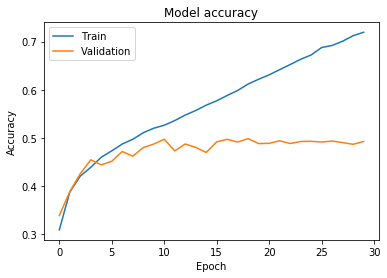

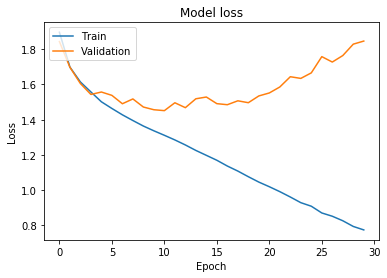

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
model.save('models/simple-nn.h5')

# Convolutional Neural Network

### Summary
* Proven to be better technique when working with images hence, much better performance that simple NN
* Achieves validation accuracy of 75% in a fairly small number of epochs

### Benifits
* Reuse of kernels/weights that are learnt and convolved over the image, thus allowing the model to learn features
* Smaller number of parameters than NN

In [13]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [14]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)       

In [15]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 11s 272us/sample - loss: 1.5455 - acc: 0.4406 - val_loss: 1.3064 - val_acc: 0.5381
Epoch 2/30
40000/40000 [==============================] - 10s 251us/sample - loss: 1.1448 - acc: 0.5945 - val_loss: 0.9539 - val_acc: 0.6662
Epoch 3/30
40000/40000 [==============================] - 10s 253us/sample - loss: 0.9772 - acc: 0.6581 - val_loss: 0.9011 - val_acc: 0.6859
Epoch 4/30
40000/40000 [==============================] - 10s 256us/sample - loss: 0.8838 - acc: 0.6928 - val_loss: 0.9369 - val_acc: 0.6750
Epoch 5/30
40000/40000 [==============================] - 10s 256us/sample - loss: 0.8189 - acc: 0.7147 - val_loss: 0.7752 - val_acc: 0.7288
Epoch 6/30
40000/40000 [==============================] - 10s 255us/sample - loss: 0.7809 - acc: 0.7303 - val_loss: 0.7276 - val_acc: 0.7449
Epoch 7/30
40000/40000 [==============================] - 10s 254us/sample - loss: 0.

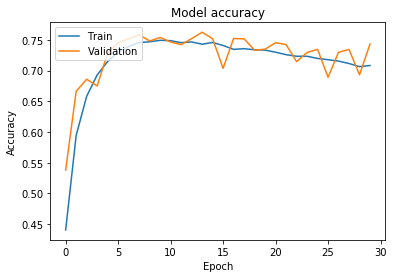

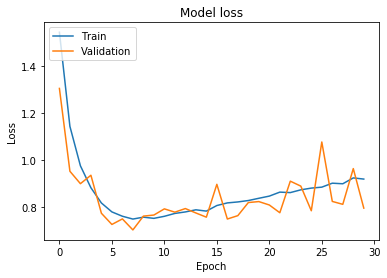

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.save('models/simple-cnn-model.h5')

# CNN WITH SEPERABLE CONVOLUTIONS

### Summary
* Much less amount of computations involved due to use of depthwise and pointwise convolutions
* Still achieved validation accuracy similar to plain CNN
* Efficient and Faster for inference and training

In [18]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

In [19]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 32)       

In [20]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 11s 271us/sample - loss: 1.7489 - acc: 0.3676 - val_loss: 1.5039 - val_acc: 0.4541
Epoch 2/30
40000/40000 [==============================] - 12s 289us/sample - loss: 1.4056 - acc: 0.4924 - val_loss: 1.3566 - val_acc: 0.5088
Epoch 3/30
40000/40000 [==============================] - 11s 268us/sample - loss: 1.2750 - acc: 0.5413 - val_loss: 1.2394 - val_acc: 0.5523
Epoch 4/30
40000/40000 [==============================] - 11s 274us/sample - loss: 1.1779 - acc: 0.5811 - val_loss: 1.2259 - val_acc: 0.5699
Epoch 5/30
40000/40000 [==============================] - 11s 282us/sample - loss: 1.1067 - acc: 0.6076 - val_loss: 1.1053 - val_acc: 0.6117
Epoch 6/30
40000/40000 [==============================] - 10s 257us/sample - loss: 1.0553 - acc: 0.6265 - val_loss: 1.0610 - val_acc: 0.6256
Epoch 7/30
40000/40000 [==============================] - 11s 272us/sample - loss: 1.

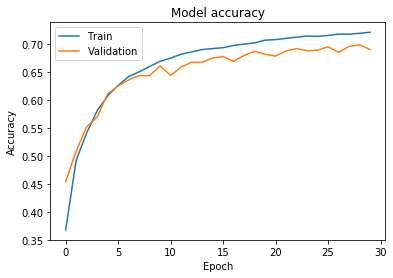

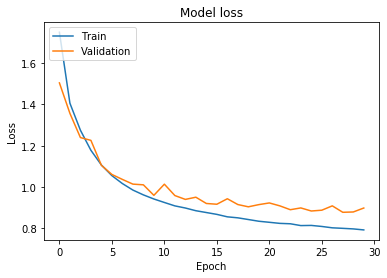

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.save('models/seperable-cnn-model.h5')

# CNN 64x3

### Summary
* Much more params that any other CNN thus a more complex of a model
* Using kernel regularizer of 0.0001 to prevent high variance, tried using 0.001 but achieved worse results
* Best model in all of the experiments in terms of validation accuracy
* Takes longer to train overall

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

model = Sequential()

weight_decay = 0.0001
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))

In [24]:
from tensorflow.keras.optimizers import Adam

# initiate RMSprop optimizer
opt = Adam(learning_rate=0.001)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)       

In [25]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=30, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 14s 339us/sample - loss: 1.7384 - acc: 0.4254 - val_loss: 1.2790 - val_acc: 0.5515
Epoch 2/30
40000/40000 [==============================] - 13s 333us/sample - loss: 1.1522 - acc: 0.6070 - val_loss: 1.0049 - val_acc: 0.6645
Epoch 3/30
40000/40000 [==============================] - 13s 326us/sample - loss: 0.9520 - acc: 0.6821 - val_loss: 0.8809 - val_acc: 0.7082
Epoch 4/30
40000/40000 [==============================] - 13s 331us/sample - loss: 0.8444 - acc: 0.7206 - val_loss: 0.7543 - val_acc: 0.7536
Epoch 5/30
40000/40000 [==============================] - 14s 338us/sample - loss: 0.7751 - acc: 0.7499 - val_loss: 0.7054 - val_acc: 0.7697
Epoch 6/30
40000/40000 [==============================] - 13s 330us/sample - loss: 0.7324 - acc: 0.7673 - val_loss: 0.7414 - val_acc: 0.7632
Epoch 7/30
40000/40000 [==============================] - 13s 332us/sample - loss: 0.

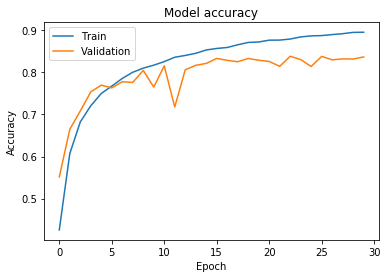

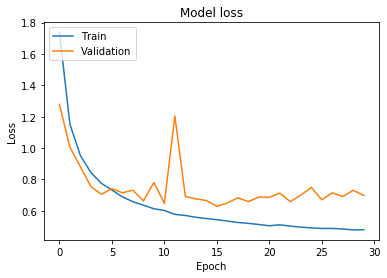

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
model.save('models/deep-cnn-model.h5')

## Test Set Analysis
### Summary:
* As expected, depp-cnn-model (64x3 CNN) has the highest test accuracy of 83%
* Better results should be achieveable by using data augmentation as well as more complex architectures

In [20]:
def load_models():
    from tensorflow.keras.models import load_model
    import os
    
    all_models = []
    for model in os.listdir('models'):
        all_models.append((model,load_model('models/'+model)))
    
    return all_models

In [21]:
models = load_models()

In [22]:
for model in models:
    print(f'Evaluating {model[0]}')
    if len(model[1].input_shape) == 4:
        model[1].evaluate(x=convert_data_for_cnn(test_x,10000), y=test_y)
    else:
        model[1].evaluate(x=test_x, y=test_y)

Evaluating deep-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 3s 318us/sample - loss: 0.7082 - acc: 0.8371
Evaluating seperable-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 2s 163us/sample - loss: 0.8914 - acc: 0.6955
Evaluating simple-nn.h5
10000/10000 [==============================] - 1s 100us/sample - loss: 416.9442 - acc: 0.4431
Evaluating simple-cnn-model.h5
(10000, 3, 32, 32)
10000/10000 [==============================] - 2s 233us/sample - loss: 0.8051 - acc: 0.7457


## BONUS: Resnet

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [21]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [22]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [23]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [24]:
model = resnet_v1(input_shape=(32,32,3), depth=20)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 16)   0           batch_normalization_38[0][0]     
______________________________________________________________________

In [25]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [27]:
history = model.fit(convert_data_for_cnn(data), labels,
              batch_size=64,
              epochs=200,
              validation_split=0.2,
              shuffle=True, callbacks=callbacks)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/200
40000/40000 [==============================] - 23s 583us/sample - loss: 0.3872 - acc: 0.9346 - val_loss: 1.4657 - val_acc: 0.6960
Learning rate:  0.001
Epoch 2/200
40000/40000 [==============================] - 23s 583us/sample - loss: 0.3793 - acc: 0.9385 - val_loss: 1.4869 - val_acc: 0.7084
Learning rate:  0.001
Epoch 3/200
40000/40000 [==============================] - 23s 583us/sample - loss: 0.3658 - acc: 0.9439 - val_loss: 1.3018 - val_acc: 0.7250
Learning rate:  0.001
Epoch 4/200
40000/40000 [==============================] - 23s 579us/sample - loss: 0.3611 - acc: 0.9468 - val_loss: 1.3480 - val_acc: 0.7212
Learning rate:  0.001
Epoch 5/200
40000/40000 [==============================] - 23s 583us/sample - loss: 0.3630 - acc: 0.9466 - val_loss: 1.5464 - val_acc: 0.7113
Learning rate:  0.001
Epoch 6/200
40000/40000 [==============================] - 23s 581us/sample - loss: 0.352

KeyboardInterrupt: 

In [3]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 15
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch

Learning rate:  0.001
Epoch 1/15
1562/1563 [============================>.] - ETA: 0s - loss: 1.5726 - acc: 0.4874
Epoch 00001: val_acc improved from -inf to 0.49750, saving model to /home/nagianek/projects/cifar-10/saved_models/cifar10_ResNet20v1_model.001.h5
1563/1563 [==============================] - 49s 32ms/step - loss: 1.5725 - acc: 0.4874 - val_loss: 1.6345 - val_acc: 0.4975
Learning rate:  0.001
Epoch 2/15
1562/1563 [============================>.] - ETA: 0s - loss: 1.2008 - acc: 0.6333
Epoch 00002: val_acc improved from 0.49750 to 0.61110, saving model to /home/nagianek/projects/cifar-10/saved_models/cifar10_ResNet20v1_model.002.h5
1563/1563 [==============================] - 43s 28ms/step - loss: 1.2009 - acc: 0.6333 - val_loss: 1.2931 - val_acc: 0.6111
Learning rate:  0.001
Epoch 3/15
1561/1563 [============================>.] - ETA: 0s - loss: 1.0334 - acc: 0.6956
Epoch 00003: val_acc improved from 0.61110 to 0.68140, saving model to /home/nagianek/projects/cifar-10/saved_